# LTIs, FFTs, FRFs, PSDs, CSDs, TFs, ...

Table of contents:

[Preamble](#Preamble)

[LTI system setup](#LTI-system-setup)

[SS system setup](#SS-system-setup)

[Check system](#Check-system)

[Noise generation functions](#Noise-generation-functions)

[Generate noise](#Generate-noise)

[Histograms](#Histograms)

[FFT, PSD](#FFT,-PSD)

[Coloured noise](#Coloured-noise)

References:

[LabVIEW Frequency analysis](http://zone.ni.com/reference/en-XX/help/371361L-01/TOC102.htm)

[LabVIEW FRF](http://zone.ni.com/reference/en-XX/help/371361L-01/lvanlsconcepts/frequency_response_function/)

[LabVIEW Coherence function](http://zone.ni.com/reference/en-XX/help/371361L-01/lvanlsconcepts/lvac_coherence_function/)

[LabVIEW FRF Mag-Phase](http://zone.ni.com/reference/en-XX/help/371361L-01/lvwave/freq_resp_func_mag_phase/)

[LabVIEW FRF Real-Im](http://zone.ni.com/reference/en-XX/help/371361L-01/lvwave/freq_resp_func_real_im/)

## Preamble

Computational environment setup

In [13]:
from __future__ import division, print_function

import numpy as np
from numpy import linalg as LA
from numpy import random

from scipy import signal

from matplotlib import mlab
import matplotlib.pyplot as plt

%matplotlib inline

## LTI system setup

[LTI systems](http://en.wikipedia.org/wiki/LTI_system_theory)

In [14]:
MM = np.matrix(np.diag([1.,2.])) # mass matrix
KK = np.matrix([[20.,-10.],[-10.,10.]]) # stiffness matrix
C1 = 0.1*MM + 0.02*KK # proportional damping matrix

## SS system setup

[SS systems](http://en.wikipedia.org/wiki/State-space_representation)

In [15]:
A = np.bmat([[np.zeros_like(MM), np.identity(MM.shape[0])], [LA.solve(-MM,KK), LA.solve(-MM,C1)]]) # system matrix

Bf = KK*np.asmatrix(np.ones((2, 1)))
B = np.bmat([[np.zeros_like(Bf)],[LA.solve(MM,Bf)]]) # input matrix

Cd = np.matrix((1,0)) # displacement output
Cv = np.asmatrix(np.zeros((1,MM.shape[1]))) # velocity output
Ca = np.asmatrix(np.zeros((1,MM.shape[1]))) # acceleration output
C = np.bmat([Cd-Ca*LA.solve(MM,KK),Cv-Ca*LA.solve(MM,C1)]) # output matrix

D = Ca*LA.solve(MM,Bf) # feedthrough matrix

system = signal.lti(A, B, C, D)

## Check system

In [16]:
w1, v1 = LA.eig(A)

ix = np.argsort(np.absolute(w1)) # order of ascending eigenvalues
w1 = w1[ix] # sorted eigenvalues
v1 = v1[:,ix] # sorted eigenvectors
zw = -w1.real # damping coefficient time angular frequency
wD = w1.imag # damped angular frequency
zn = 1./np.sqrt(1.+(wD/-zw)**2) # the minus sign is formally correct!
wn = zw/zn # undamped angular frequency

print('Angular frequency: {}'.format(wn[[0,2]]))
print('Damping coefficient: {}'.format(zn[[0,2]]))

Angular frequency: [ 1.48062012  4.77574749]
Damping coefficient: [ 0.04857584  0.05822704]


## Bode plot

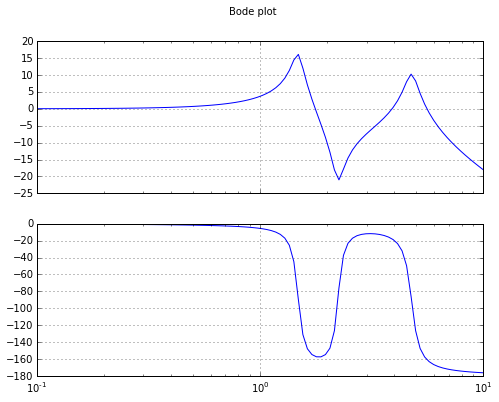

In [17]:
w, mag, phase = signal.bode(system)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
fig.suptitle('Bode plot')
ax1.semilogx(w, mag)
ax1.grid(True)
ax2.semilogx(w, phase)
ax2.grid(True)
plt.show()

## Real and imaginary plots

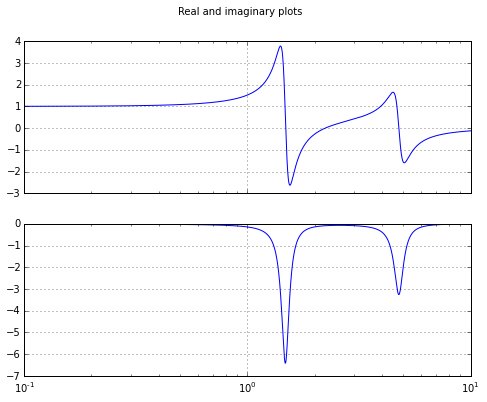

In [18]:
w, H = signal.freqresp(system)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
fig.suptitle('Real and imaginary plots')
ax1.semilogx(w, H.real)
ax1.grid(True)
ax2.semilogx(w, H.imag)
ax2.grid(True)
plt.show()

## Noise generation functions

[Uniform white noise](http://zone.ni.com/reference/en-XX/help/371361L-01/lvanls/uniform_white_noise/)

[Periodic random noise](http://zone.ni.com/reference/en-XX/help/371361L-01/lvanls/periodic_random_noise/)

[NumPy irfft function](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.irfft.html#numpy.fft.irfft)

In [19]:
def UWN(n):
    """Uniform white noise."""
    return random.random_sample(n)

def PRN(n):
    """Periodic random noise."""
    values = np.fft.irfft(np.exp(2j*np.pi*random.random_sample(n//2+1)), n=n)
    maxval = np.max(values)
    minval = np.min(values)
    return (values-minval)/(maxval-minval)

## Generate noise

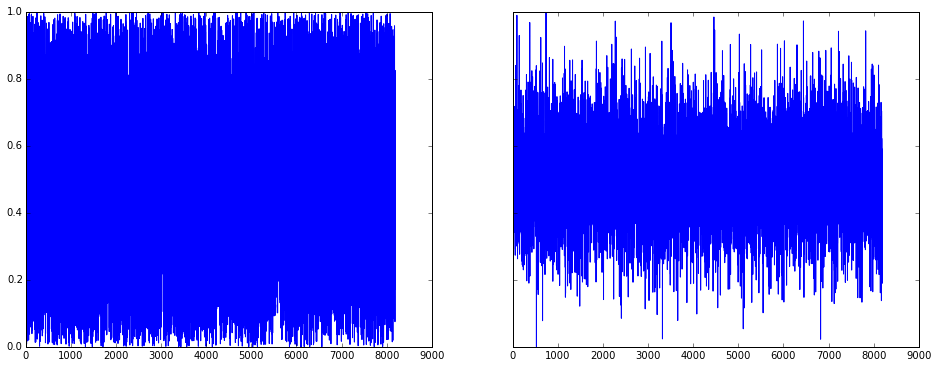

In [20]:
N = 8192

uwn = UWN(N)
prn = PRN(N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)
ax1.plot(uwn)
ax2.plot(prn)
plt.show()

## Histograms

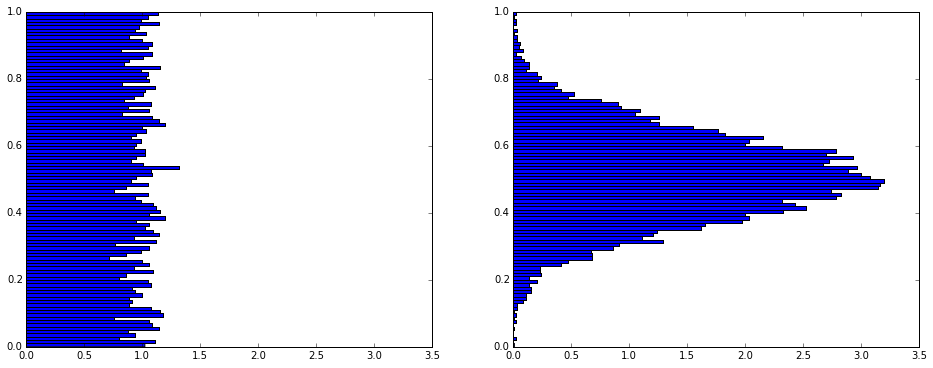

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharex=True)
ax1.hist(uwn, bins=100, normed=True, orientation=u'horizontal')
ax2.hist(prn, bins=100, normed=True, orientation=u'horizontal')
plt.show()

## FFT, PSD

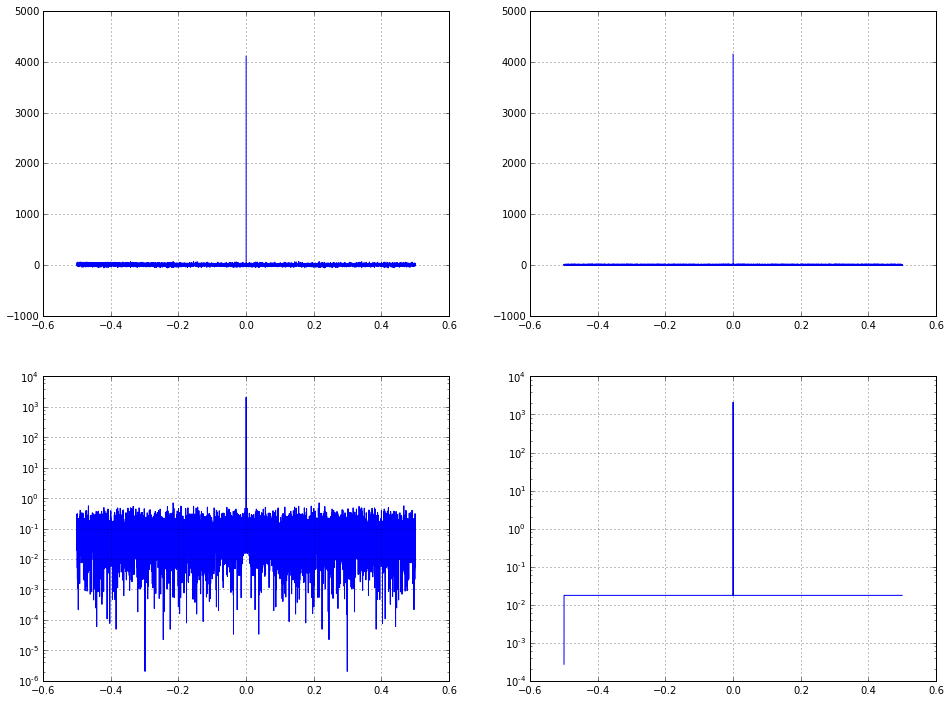

In [22]:
Fs = 1.
freq = np.fft.fftfreq(N, d=1./Fs)

UU = np.fft.fft(uwn)
PP = np.fft.fft(prn)

(Puu, freqs) = mlab.psd(uwn, NFFT=N, Fs=Fs, window=mlab.window_none, sides='twosided', scale_by_freq=True)
(Ppp, freqs) = mlab.psd(prn, NFFT=N, Fs=Fs, window=mlab.window_none, sides='twosided', scale_by_freq=True)

fig, ax = plt.subplots(2, 2, figsize=(16,12))
ax[0, 0].plot(freq, UU.real)
ax[0, 0].grid(True)
ax[0, 1].plot(freq, PP.real)
ax[0, 1].grid(True)
ax[1, 0].semilogy(freqs, Puu)
ax[1, 0].grid(True)
ax[1, 1].semilogy(freqs, Ppp)
ax[1, 1].grid(True)
plt.show()

## Coloured noise

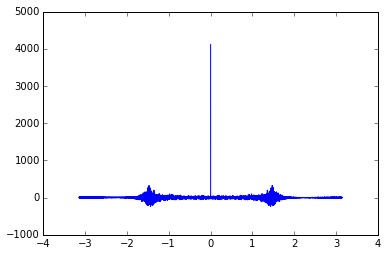

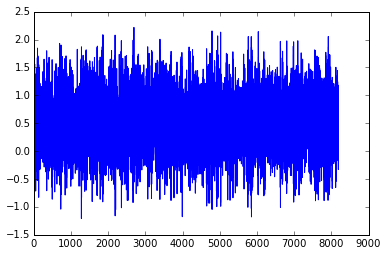

In [23]:
w, H = signal.freqresp(system, w=2.*np.pi*freq)

AAA = UU*H
aaa = np.fft.ifft(AAA)

plt.figure()
plt.plot(w, AAA.real)
plt.show()

plt.figure()
plt.plot(aaa)
plt.show()

What next?